In [1]:
import numpy as np
import ephem
from datetime import datetime
import matplotlib.pyplot as plt
from typing import NamedTuple
import pandas as pd

In [2]:
class Result(NamedTuple):
    sunrise: datetime
    sunset: datetime
    day_length: float # in hours
    sunrise_azimuth: float # in degrees, 0 - north, 180 - south
    sunset_azimuth: float # in degrees


def get_sunrise_sunset(latitude, longitude, date):
    observer = ephem.Observer()
    observer.lat, observer.lon = str(latitude), str(longitude)
    observer.date = date
    
    sun = ephem.Sun()
    sunrise = observer.next_rising(sun).datetime()
    sunset = observer.next_setting(sun).datetime()
    day_length = round((sunset - sunrise).seconds / 3600, 3)

    observer.date = sunrise
    sun.compute(observer)
    sunrise_azimuth = sun.az * 180 / np.pi

    observer.date = sunset
    sun.compute(observer)
    sunset_azimuth = sun.az * 180 / np.pi

    return Result(sunrise, sunset, day_length, sunrise_azimuth, sunset_azimuth)

latitude = 52.2297  # Warsaw
longitude = 21.0122  # Warsaw

dates = pd.date_range(start='2024-03-21', end='2025-03-21', freq='D')
results = [get_sunrise_sunset(latitude, longitude, date) for date in dates]

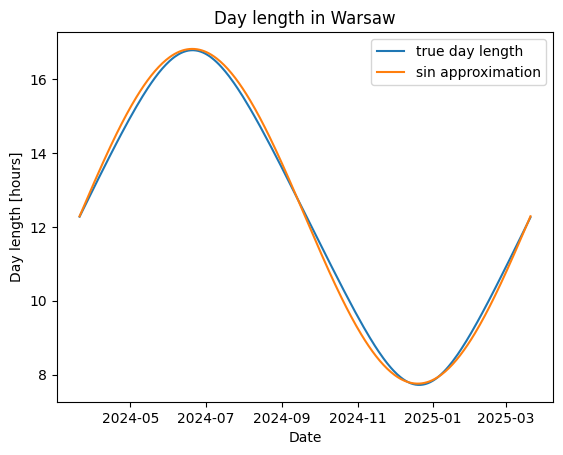

In [3]:
day_lengths = np.array([result.day_length for result in results])

min_day_length = day_lengths.min()
max_day_length = day_lengths.max()
avg_day_length = day_lengths.mean()

day_sin = (np.sin(2 * np.pi * np.arange(len(day_lengths)) / 365) * (max_day_length - min_day_length) / 2 + avg_day_length)

plt.plot(dates, day_lengths, label='true day length')
plt.plot(dates, day_sin, label='sin approximation')
plt.title('Day length in Warsaw')
plt.xlabel('Date')
plt.ylabel('Day length [hours]')
plt.legend()
plt.show()

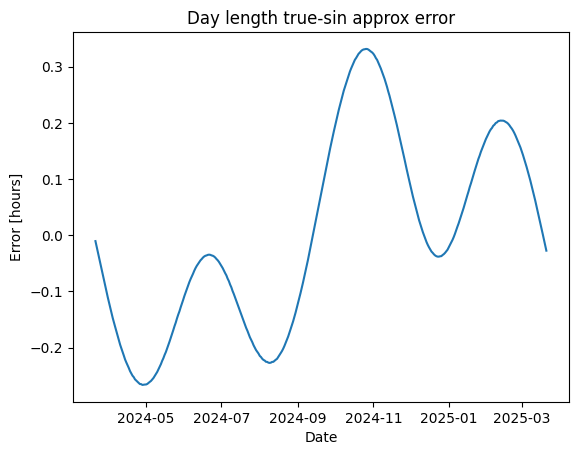

In [4]:
day_length_error = day_lengths - day_sin
plt.plot(dates, day_length_error)
plt.title('Day length true-sin approx error')
plt.xlabel('Date')
plt.ylabel('Error [hours]')
plt.show()

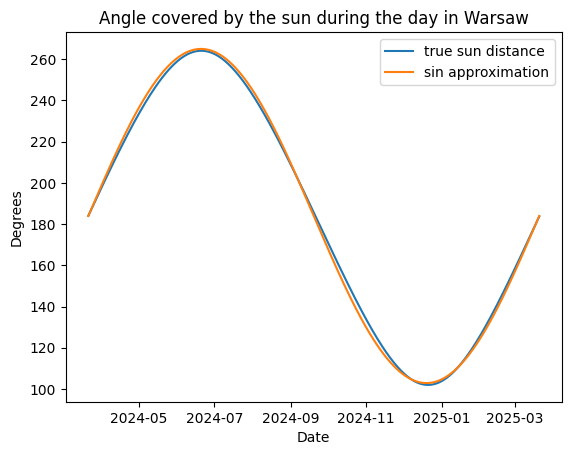

In [5]:
sunrise_azimuths = np.array([result.sunrise_azimuth for result in results])
sunset_azimuths = np.array([result.sunset_azimuth for result in results])
total_sun_distance = np.abs(sunrise_azimuths - sunset_azimuths)
min_sun_distance = total_sun_distance.min()
max_sun_distance = total_sun_distance.max()
avg_sun_distance = total_sun_distance.mean()
sin_approx_sun_distance = (np.sin(2 * np.pi * np.arange(len(total_sun_distance)) / 365) * (max_sun_distance - min_sun_distance) / 2 + avg_sun_distance)

plt.plot(dates, total_sun_distance, label='true sun distance')
plt.plot(dates, sin_approx_sun_distance, label='sin approximation')
plt.title('Angle covered by the sun during the day in Warsaw')
plt.xlabel('Date')
plt.ylabel('Degrees')
plt.legend()
plt.show()

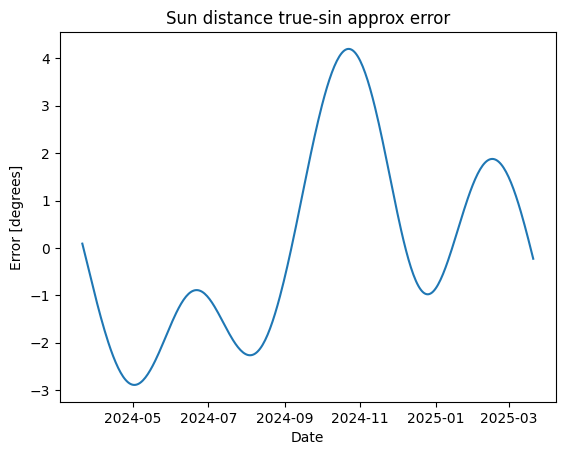

In [6]:
sun_distance_error = total_sun_distance - sin_approx_sun_distance
plt.plot(dates, sun_distance_error)
plt.title('Sun distance true-sin approx error')
plt.xlabel('Date')
plt.ylabel('Error [degrees]')
plt.show()

The exact halfway between the autumn equinox and the winter solstice in terms of how much the sun will move on horizon during the sunrise/sunset:

In [7]:
query_distance = (avg_sun_distance + min_sun_distance) / 2
halfway_date_index = np.abs(total_sun_distance - query_distance).argmin()
sun_halfway_date = dates[halfway_date_index]
sun_halfway_date

Timestamp('2024-10-24 00:00:00')

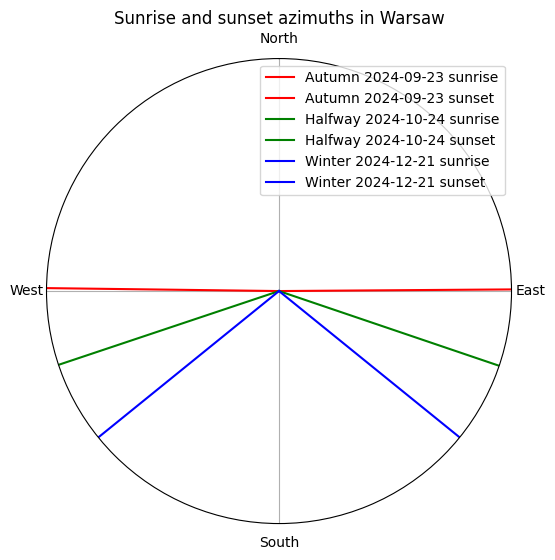

In [8]:
# Plot with autumn equinox and winter solstice
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 10))
autumn_equinox_date_index = np.where(dates == '2024-09-23')[0][0]
winter_solstice_date_index = np.where(dates == '2024-12-21')[0][0]
autumn_sunrise_azimuth = sunrise_azimuths[autumn_equinox_date_index]
winter_sunrise_azimuth = sunrise_azimuths[winter_solstice_date_index]
autumn_sunset_azimuth = sunset_azimuths[autumn_equinox_date_index]
winter_sunset_azimuth = sunset_azimuths[winter_solstice_date_index]
halfway_sunrise_azimuth = sunrise_azimuths[halfway_date_index]
halfway_sunset_azimuth = sunset_azimuths[halfway_date_index]


ax.plot([autumn_sunrise_azimuth * np.pi / 180, autumn_sunrise_azimuth * np.pi / 180], [0, 1], label='Autumn 2024-09-23 sunrise', color='red')
ax.plot([autumn_sunset_azimuth * np.pi / 180, autumn_sunset_azimuth * np.pi / 180], [0, 1], label='Autumn 2024-09-23 sunset', color='red')
ax.plot([halfway_sunrise_azimuth * np.pi / 180, halfway_sunrise_azimuth * np.pi / 180], [0, 1], label='Halfway 2024-10-24 sunrise', color='green')
ax.plot([halfway_sunset_azimuth * np.pi / 180, halfway_sunset_azimuth * np.pi / 180], [0, 1], label='Halfway 2024-10-24 sunset', color='green')
ax.plot([winter_sunrise_azimuth * np.pi / 180, winter_sunrise_azimuth * np.pi / 180], [0, 1], label='Winter 2024-12-21 sunrise', color='blue')
ax.plot([winter_sunset_azimuth * np.pi / 180, winter_sunset_azimuth * np.pi / 180], [0, 1], label='Winter 2024-12-21 sunset', color='blue')

ax.set_theta_zero_location('N')
ax.set_rlim([0, 1])
ax.set_rticks([])
ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
ax.set_xticklabels(['North', 'West', 'South', 'East'])
ax.legend()
ax.title.set_text('Sunrise and sunset azimuths in Warsaw')
plt.show()